# Define Running Mode

'performance_validation = True' when validating the performance of the model based on last 28 training days.  
  
    
'performance_validation = False' when computing forecasts that will be submitted to Kaggle.  


In [1]:
performance_validation = True

# Import Packages

In [2]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
from sklearn.metrics import mean_squared_error

# Data Import and Preparation

In [3]:
if performance_validation is True:
    # Import data
    submission = pd.read_csv(
        f'{utils.get_m5_root_dir()}/data/input/sample_submission.csv')
    df_merged = pd.read_csv(
        f'{utils.get_m5_root_dir()}/data/preprocessed/tx2_hobbies_1year.csv')

    # take only values where target value is known
    df_merged = df_merged.loc[df_merged['data_type'] == 'train']

    # extract target values (last 28 days) in seperate list
    y_test = df_merged[(df_merged['date'] > '2016-03-27')]['sale']

    # replace target values in DataFrame with NaN
    df_merged['sale'].loc[df_merged['date'] > '2016-03-27'] = np.nan

else:
    # Import data
    submission = pd.read_csv(
        f'{utils.get_m5_root_dir()}/data/input/sample_submission.csv')
    df_merged = pd.read_csv(
        f'{utils.get_m5_root_dir()}/data/preprocessed/preprocessed_input_data.csv')

    # extract training and validation data (drop evaluation)
    df_merged = df_merged.loc[df_merged['data_type'] != 'evaluation']

In [4]:
# downcast numerical values to reduce mem usage
df_merged = utils.reduce_mem_usage(df_merged)

Mem. usage of decreased to 25.51 Mb (32.8% reduction)


In [5]:
# Convert categorical features to integers as the categorical values cause problems when using large datasets

df_merged = utils.encode_categorical(df_merged, [
    "item_id", "dept_id", "cat_id", "store_id", "state_id", "event_name_1",
    "event_type_1", "event_name_2", "event_type_2", 'd'
])

df_merged.head(10)

Mem. usage of decreased to 13.64 Mb (28.9% reduction)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sale,date,wm_yr_wk,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,data_type
0,HOBBIES_1_001_TX_2_validation,0,0,0,0,0,0,0.0,2015-04-24,11512,...,2015,13,1,0,0,0,0,0,8.26,train
1,HOBBIES_1_002_TX_2_validation,1,0,0,0,0,0,1.0,2015-04-24,11512,...,2015,13,1,0,0,0,0,0,3.97,train
2,HOBBIES_1_003_TX_2_validation,2,0,0,0,0,0,0.0,2015-04-24,11512,...,2015,13,1,0,0,0,0,0,2.97,train
3,HOBBIES_1_004_TX_2_validation,3,0,0,0,0,0,0.0,2015-04-24,11512,...,2015,13,1,0,0,0,0,0,4.64,train
4,HOBBIES_1_005_TX_2_validation,4,0,0,0,0,0,0.0,2015-04-24,11512,...,2015,13,1,0,0,0,0,0,2.73,train
5,HOBBIES_1_006_TX_2_validation,5,0,0,0,0,0,0.0,2015-04-24,11512,...,2015,13,1,0,0,0,0,0,1.00,train
6,HOBBIES_1_007_TX_2_validation,6,0,0,0,0,0,0.0,2015-04-24,11512,...,2015,13,1,0,0,0,0,0,7.88,train
7,HOBBIES_1_008_TX_2_validation,7,0,0,0,0,0,2.0,2015-04-24,11512,...,2015,13,1,0,0,0,0,0,0.48,train
8,HOBBIES_1_009_TX_2_validation,8,0,0,0,0,0,1.0,2015-04-24,11512,...,2015,13,1,0,0,0,0,0,1.63,train
9,HOBBIES_1_010_TX_2_validation,9,0,0,0,0,0,0.0,2015-04-24,11512,...,2015,13,1,0,0,0,0,0,2.97,train


# Feature Engineering

In [6]:
# sales data

# rolling mean and rolling std (weekly, monthly, quarterly, and half-year)
df_merged['rolling_mean_t7'] = df_merged.groupby(
    ['id'])['sale'].transform(lambda x: x.shift(28).rolling(7).mean())

df_merged['rolling_std_t7'] = df_merged.groupby(
    ['id'])['sale'].transform(lambda x: x.shift(28).rolling(7).std())

df_merged['rolling_mean_t30'] = df_merged.groupby(
    ['id'])['sale'].transform(lambda x: x.shift(28).rolling(30).mean())

df_merged['rolling_std_t30'] = df_merged.groupby(
    ['id'])['sale'].transform(lambda x: x.shift(28).rolling(30).std())

df_merged['rolling_mean_t90'] = df_merged.groupby(
    ['id'])['sale'].transform(lambda x: x.shift(28).rolling(90).mean())

df_merged['rolling_std_t90'] = df_merged.groupby(
    ['id'])['sale'].transform(lambda x: x.shift(28).rolling(90).std())

# laged values
df_merged['lag_t30'] = df_merged.groupby(
    ['id'])['sale'].transform(lambda x: x.shift(30))

In [7]:
# price data
df_merged['lag_price_t1'] = df_merged.groupby(
    ['id'])['sell_price'].transform(lambda x: x.shift(1))

df_merged['rolling_price_max_t30'] = df_merged.groupby(
    ['id'])['sell_price'].transform(lambda x: x.shift(1).rolling(30).max())

df_merged['price_change_t1'] = (df_merged['lag_price_t1'] -
                                df_merged['sell_price']) / (
                                    df_merged['lag_price_t1'])

df_merged['price_change_t30'] = (df_merged['rolling_price_max_t30'] -
                                 df_merged['sell_price']) / (
                                     df_merged['rolling_price_max_t30'])

df_merged['rolling_price_std_t7'] = df_merged.groupby(
    ['id'])['sell_price'].transform(lambda x: x.rolling(7).std())

df_merged['rolling_price_std_t30'] = df_merged.groupby(
    ['id'])['sell_price'].transform(lambda x: x.rolling(30).std())

df_merged.drop(['rolling_price_max_t30', 'lag_price_t1'], inplace=True, axis=1)

In [8]:
# date data
df_merged["is_weekend"] = df_merged["wday"].isin([1, 2]).astype(np.int8)

df_merged.loc[:, 'date'] = pd.to_datetime(df_merged['date'])
df_merged['day'] = df_merged['date'].dt.day.astype(np.int8)

In [9]:
# TODO: proper feature selection (e.g. random forrest)
# for now: hardcoded list of features
features = [
    'item_id',
    'dept_id',
    'cat_id',
    'store_id',
    'state_id',
    'year',
    'month',
    'day',
    'is_weekend',
    'wday',
    'event_name_1',
    'event_type_1',
    'event_name_2',
    'event_type_2',
    'snap_CA',
    'snap_TX',
    'snap_WI',
    'sell_price',
    'lag_t30',
    'rolling_mean_t7',
    'rolling_std_t7',
    'rolling_mean_t30',
    'rolling_std_t30',
    'rolling_mean_t90',
    'rolling_std_t90',
    'price_change_t1',
    'rolling_price_std_t7',
    'rolling_price_std_t30',
]

In [10]:
# drop lines with missing values that occur due to feature engineering
df_merged = df_merged.dropna(subset=features)

# Prepare Data for Training

In [11]:
if performance_validation:
    x_train = df_merged[df_merged['date'] <= '2016-03-27'][features]
    y_train = df_merged[df_merged['date'] <= '2016-03-27']['sale']
    x_val = df_merged[(df_merged['date'] > '2016-03-27')][features]
    y_val = y_test

else:
    x_train = df_merged[df_merged['data_type'] == 'train'][features]
    y_train = df_merged[df_merged['data_type'] == 'train']['sale']
    x_val = df_merged[(df_merged['data_type'] == 'validation')][features]
    y_val = df_merged[(df_merged['data_type'] == 'validation')]['sale']
    # -> y_val always NA

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(125426, 28)
(125426,)
(15820, 28)
(15820,)


# Model Training & Forecasting (GradientBoostingRegressor)

In [12]:
# docu of classifier: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

clf = GradientBoostingRegressor(n_iter_no_change=5, tol=0.005, verbose=1)
clf = clf.fit(x_train, y_train)

y_pred = clf.predict(x_val)

      Iter       Train Loss   Remaining Time 
         1           2.9893           24.89s
         2           2.8448           25.31s
         3           2.7278           25.28s
         4           2.6305           24.94s
         5           2.5516           24.33s
         6           2.4875           23.77s
         7           2.4342           23.31s
         8           2.3907           22.89s
         9           2.3549           22.63s
        10           2.3259           22.33s
        20           2.2000           19.33s


# Training Analysis

In [13]:
if performance_validation:

    # R-Squared value
    print('R-Squared Value: %0.3f' % clf.score(x_val, y_val))

    # MSE of computed forecasts
    print('MSE of computed forecasts: %0.3f' %
          mean_squared_error(y_val, y_pred))

    # MSE of SARIMA
    print('MSE of SARIMA on small data set', 3.565)
    print('MSE of SARIMA on entire data set', 7.615)

R-Squared Value: 0.262
MSE of computed forecasts: 2.120
MSE of SARIMA on small data set 3.565
MSE of SARIMA on entire data set 7.615


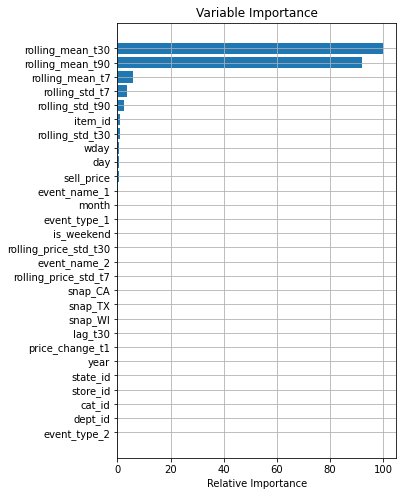

In [14]:
# Plot feature importances
feature_importance = clf.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(5, 8))
plt.grid()
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Text(0, 0.5, 'Deviance')

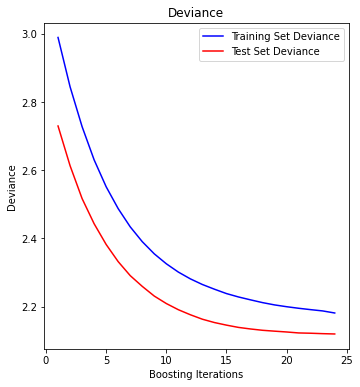

In [15]:
# Plot training deviance

test_score = np.zeros((len(clf.estimators_), ), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(x_val)):
    test_score[i] = clf.loss_(y_val, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(len(clf.estimators_)) + 1,
         clf.train_score_,
         'b-',
         label='Training Set Deviance')
plt.plot(np.arange(len(clf.estimators_)) + 1,
         test_score,
         'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# Printout Forecasts

In [16]:
# map forecast values to encoded item_ids
x_val['y_pred'] = y_pred

In [17]:
# map encoded ids to decoded ids
id_mapping_table = df_merged[['id', 'item_id', 'store_id']].drop_duplicates()
df_results = x_val.merge(id_mapping_table,
                         on=['item_id', 'store_id'],
                         how='left')[[
                             'id', 'item_id', 'store_id', 'year', 'month',
                             'day', 'y_pred'
                         ]]

In [18]:
# create dict with IDs and forecasts
submission_dict = {}

for i, df in df_results.groupby(['id']):
    df = df.reset_index(drop=True)
    submission_dict[i] = df['y_pred']

In [19]:
# convert dict to dataframe
submission_df = pd.DataFrame(submission_dict).T
submission_df.reset_index(level=0, inplace=True)
submission_df.columns = ['id'] + [f'F{di}' for di in list(range(1, 29))]
submission_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_TX_2_validation,0.503223,0.503223,0.503223,0.503223,0.503223,0.517811,0.402066,0.387478,0.387478,...,0.373536,0.388123,0.388123,0.351484,0.351484,0.351484,0.418961,0.418961,0.474879,0.474879
1,HOBBIES_1_002_TX_2_validation,0.216299,0.216299,0.216299,0.216299,0.216299,0.230887,0.230887,0.216299,0.216299,...,0.208748,0.223335,0.223335,0.208748,0.208748,0.208748,0.208748,0.208748,0.223335,0.223335
2,HOBBIES_1_003_TX_2_validation,0.216299,0.216299,0.216299,0.216299,0.216299,0.230887,0.230887,0.216299,0.216299,...,0.208748,0.223335,0.223335,0.208748,0.208748,0.208748,0.208748,0.208748,0.223335,0.223335
3,HOBBIES_1_004_TX_2_validation,0.815861,0.748704,0.748704,0.748704,0.748704,0.754063,0.754063,0.666280,0.666280,...,0.740023,0.839410,0.728347,0.896648,0.839931,0.839931,0.756354,1.013654,1.109514,1.075298
4,HOBBIES_1_005_TX_2_validation,0.546556,0.546556,0.546556,0.546556,0.514432,0.529020,0.466124,0.451536,0.408203,...,0.499859,0.513702,0.513702,0.499859,0.537691,0.537691,0.537691,0.572453,0.611747,0.611747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,HOBBIES_2_145_TX_2_validation,0.291809,0.291809,0.276944,0.305752,0.290886,0.291531,0.283872,0.290886,0.311611,...,0.388213,0.410461,0.410461,0.395873,0.395873,0.395873,0.395873,0.363749,0.378337,0.370677
561,HOBBIES_2_146_TX_2_validation,0.239554,0.239554,0.239554,0.239554,0.239554,0.254142,0.254142,0.225848,0.225848,...,0.303145,0.307781,0.307781,0.293193,0.366041,0.398165,0.388213,0.388213,0.402801,0.370677
562,HOBBIES_2_147_TX_2_validation,0.551994,0.542042,0.542042,0.540319,0.540319,0.589565,0.527907,0.481172,0.481172,...,0.632369,0.657405,0.657405,0.618111,0.597652,0.537691,0.537691,0.551994,0.591288,0.591288
563,HOBBIES_2_148_TX_2_validation,0.471100,0.398236,0.462294,0.418961,0.418961,0.433549,0.433549,0.418961,0.418961,...,0.295507,0.310094,0.310094,0.295507,0.295507,0.295507,0.295507,0.295507,0.310094,0.310094


# Submit to Kaggle 

In [20]:
if performance_validation is False:
    # Bring data to Kaggel's required form (evaluation & validation)
    df_submission = submission_df.append(
        submission_df.replace(to_replace='validation', value='evaluation',
                              regex=True))
    filename = utils.get_m5_root_dir(
    ) + '/data/submissions/gradient_boosting_regressor_v_1_0.csv'
    df_submission.to_csv(filename, index=False)
    

    # Submit via Kaggle API or with website https://www.kaggle.com/c/m5-forecasting-accuracy/submissions
    #!kaggle competitions submit - c m5-forecasting-accuracy - f data/submissions/gradient_boosting_regressor_v_1_0.csv - m"gradient_boosting_regressor_v_1_0.csv"